# Notebook 6 of 6 - Final Model Analysis
**Author:** Alexandru Mihalache 

**Date:** November 2022

In [1]:
import pandas as pd
import numpy as np

#Plotting liibs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# fuzz is used to compare TWO strings
from fuzzywuzzy import fuzz
# process is used to compare a string to MULTIPLE other strings
from fuzzywuzzy import process
import load_data
import pre_processing_utils as ppu
from itertools import cycle

# ML libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, label_binarize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

#Model scoring 
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, confusion_matrix, confusion_matrix, plot_confusion_matrix, mean_squared_error, r2_score, roc_curve, auc

/Users/alexmihalache/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
xt, xt_test, vaep, vaep_test, games, games_test, players, players_test, target_players = load_data.load_data()

In [28]:
modeling_train_df = vaep.copy()
modeling_test_df = vaep_test.copy()
modeling_xt_train_df = xt.copy()
modeling_xt_test_df = xt_test.copy()

In [20]:
target_players.head(5)

,player_id,player_name,minutes_played
0,24239,Jemma Elizabeth Purfield,2016
1,15579,Inessa Kaagman,2015
2,5076,Emily Louise van Egmond,1940
3,5074,Shelina Laura Zadorsky,1930
4,31534,Ella Toone,1887


In [49]:
player_id = 15579
post_transfer_team = 965
pre_transfer_team = 967

## VAEP Prediction

In [33]:
from tempfile import mkdtemp
cachedir = mkdtemp()

In [ ]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',post_transfer_team, modeling_train_df, modeling_test_df, 'vaep_value')

numeric_features_vaep, categorical_features_vaep, drop_features_vaep = ppu.set_ct_mode('team-vaep')

# define column transformed for pipeline
ct_vaep = make_column_transformer(
    (StandardScaler(), numeric_features_vaep),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_vaep),
    # ('passthrough', passthrough_features),
    ('drop', drop_features_vaep))


pipe_vaep = make_pipeline(ct_vaep, xgb.XGBRegressor(max_depth=8, gamma=0.01, reg_alpha=1.1, eta=0.1))
pipe_vaep.fit(X_train, y_train)


In [ ]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',post_transfer_team, modeling_xt_train_df, modeling_xt_test_df, 'xT_value')


numeric_features_xt, categorical_features_xt, drop_features_xt = ppu.set_ct_mode('team-xt')

# pipeline column transformer
ct_xt = make_column_transformer(
    (StandardScaler(), numeric_features_xt),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_xt),
    # ('passthrough', passthrough_features),
    ('drop', drop_features_xt))

pipe_xt = make_pipeline(ct_xt, xgb.XGBRegressor(max_depth=5, reg_lambda=200))
pipe_xt.fit(X_train, y_train)

In [ ]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',post_transfer_team, modeling_train_df, modeling_test_df, 'type_name_encoded')

numeric_features_action, categorical_features_action, drop_features_action = ppu.set_ct_mode('team-action')

ct_action = make_column_transformer(
    (StandardScaler(), numeric_features_action),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_action),
    # ('passthrough', passthrough_features),
    ('drop', drop_features_action))


pipe_action = make_pipeline(ct_action, xgb.XGBClassifier(max_depth=3, eta=0.3, gamma=0.01))
pipe_action.fit(X_train, y_train)

In [ ]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',post_transfer_team, modeling_train_df, modeling_test_df, 'end_pitch_zone')

numeric_features_end, categorical_features_end, drop_features_end = ppu.set_ct_mode('team-end')

ct_end = make_column_transformer(
    (StandardScaler(), numeric_features_end),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_end),
    # ('passthrough', passthrough_features),
    ('drop', drop_features_end))



pipe_end = make_pipeline(ct_end, xgb.XGBClassifier(max_depth=3, eta=0.3, gamma=0.01))
pipe_end.fit(X_train, y_train)

In [56]:
player_data_pre_transfer = modeling_train_df[modeling_train_df['player_id']==player_id]
player_data_pre_transfer_xt = modeling_xt_train_df[modeling_xt_train_df['player_id']==player_id]

In [57]:
vaep_pred = pipe_vaep.predict(player_data_pre_transfer)
xt_pred = pipe_xt.predict(player_data_pre_transfer_xt)
action_pred = pipe_action.predict(player_data_pre_transfer)
end_pred = pipe_end.predict(player_data_pre_transfer)

player_data_pre_transfer['vaep_pred'] = vaep_pred
player_data_pre_transfer_xt['xt_pred'] = xt_pred
player_data_pre_transfer['action_pred'] = action_pred
player_data_pre_transfer['end_pred'] = end_pred

In [68]:
print('Predicted VAEP, Pre-transfer: ', player_data_pre_transfer['vaep_pred'].sum()/30)
print(' ')
print('Predicted XT Pre-transfer: ', player_data_pre_transfer_xt['xt_pred'].sum()/30)
print(' ')
print('Actions Distribution Pre-transfer:\n', player_data_pre_transfer['action_pred'].value_counts(normalize=True))
print(' ')
print('End Zone Distribution Pre-transfer:\n', player_data_pre_transfer['end_pred'].value_counts(normalize=True))

Predicted VAEP, Pre-transfer:  0.1389993190765381
 
Predicted XT Pre-transfer:  0.0430255651473999
 
Actions Distribution Pre-transfer:
 dribble    0.449845
pass       0.380558
other      0.169597
Name: action_pred, dtype: float64
 
End Zone Distribution Pre-transfer:
 zone_6    0.206308
zone_8    0.162358
zone_9    0.142192
zone_4    0.133402
zone_7    0.111169
zone_5    0.100310
zone_3    0.062048
zone_1    0.042916
zone_2    0.039297
Name: end_pred, dtype: float64


In [64]:
vaep_test[vaep_test['player_id']==player_id]['game_id'].nunique()

22

In [69]:
print('VAEP Post-transfer: ', vaep_test[vaep_test['player_id'] == player_id]['vaep_value'].sum()/22)
print(' ')
print('XT Post-transfer: ', xt_test[xt_test['player_id'] == player_id]['xT_value'].sum()/22)
print(' ')
print('Actions Distribution Post-transfer:\n', vaep_test[vaep_test['player_id'] == player_id]['type_name_encoded'].value_counts(normalize=True))
print(' ')
print('End Zone Distribution Post-transfer:\n', vaep_test[vaep_test['player_id'] == player_id]['end_pitch_zone'].value_counts(normalize=True))

VAEP Post-transfer:  0.25302502775809543
 
XT Post-transfer:  0.05955026945349151
 
Actions Distribution Post-transfer:
 dribble    0.403344
pass       0.397324
other      0.199331
Name: type_name_encoded, dtype: float64
 
End Zone Distribution Post-transfer:
 zone_6    0.229431
zone_8    0.174582
zone_9    0.161873
zone_3    0.117726
zone_5    0.092977
zone_4    0.086957
zone_7    0.084950
zone_2    0.027425
zone_1    0.024080
Name: end_pitch_zone, dtype: float64


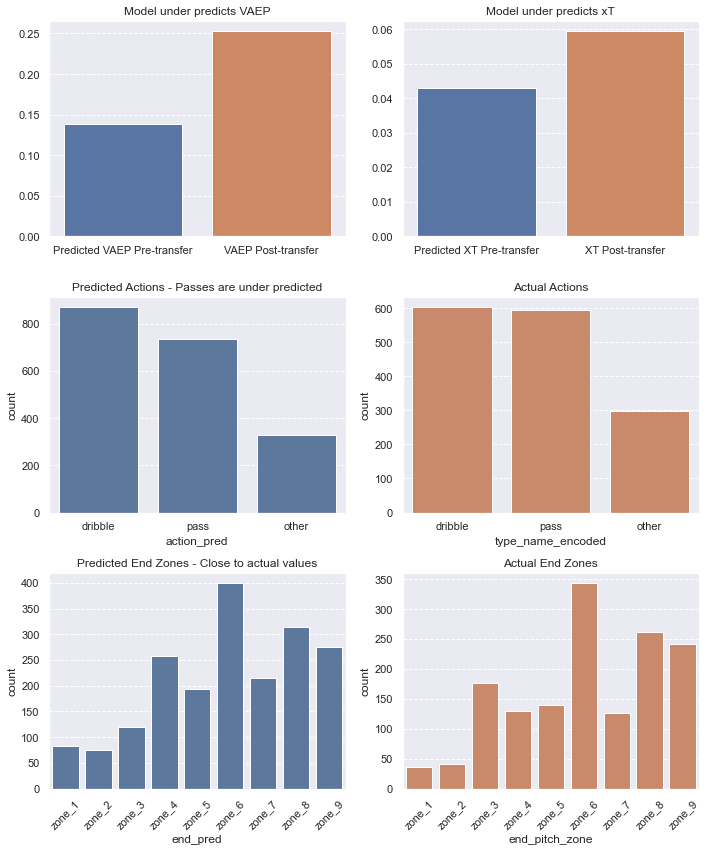

In [131]:
plt.subplots(3, 2, figsize=(10,12))
sns.set_theme()
plt.subplot(3,2,1)
sns.barplot(['Predicted VAEP Pre-transfer','VAEP Post-transfer'],[(player_data_pre_transfer['vaep_pred'].sum()/30), vaep_test[vaep_test['player_id'] == player_id]['vaep_value'].sum()/22])
plt.title('Model under predicts VAEP')
plt.grid(axis='y', linestyle = '--')

plt.subplot(3,2,2)
sns.barplot(['Predicted XT Pre-transfer','XT Post-transfer'],[player_data_pre_transfer_xt['xt_pred'].sum()/30, xt_test[xt_test['player_id'] == player_id]['xT_value'].sum()/22])
plt.title('Model under predicts xT')
plt.grid(axis='y', linestyle = '--')

plt.subplot(3,2,3)
sns.countplot(player_data_pre_transfer['action_pred'],color='#5176a8')
plt.title('Predicted Actions - Passes are under predicted')
plt.grid(axis='y', linestyle = '--')

plt.subplot(3,2,4)
sns.countplot(vaep_test[vaep_test['player_id'] == player_id]['type_name_encoded'],color='#d8855b')
plt.title('Actual Actions')
plt.grid(axis='y', linestyle = '--')

plt.subplot(3,2,5)
sns.countplot(player_data_pre_transfer['end_pred'].sort_values(), color='#5176a8')
plt.grid(axis='y', linestyle = '--')
plt.title('Predicted End Zones - Close to actual values')
plt.xticks(rotation=45)

plt.subplot(3,2,6)
sns.countplot(vaep_test[vaep_test['player_id'] == player_id]['end_pitch_zone'].sort_values(), color='#d8855b')
plt.xticks(rotation=45)
plt.title('Actual End Zones')
plt.grid(axis='y', linestyle = '--')

plt.tight_layout()
plt.show()